In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird
from importlib import reload
import os
from scipy.interpolate import interp1d
from copy import deepcopy

In [2]:
correlator = pybird.Correlator()

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

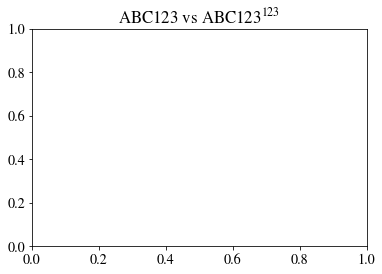

In [3]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [4]:
zpk = 0.55

In [8]:
from scipy.optimize import fsolve

def get_masses(sum_masses, hierarchy='NH'):
    # a function returning the three masses given the Delta m^2, the total mass, and the hierarchy (e.g. 'IN' or 'IH')
    # Values are in the latest PDG
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # Normal hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_NH and deletes M_tot_NH
        delta_m_squared_21 = 7.37e-5
        delta_m_squared_31 = 2.56e-3
        def m1_func(m1, M_tot):
            return M_tot**2 - (m1 + np.sqrt(m1**2 + delta_m_squared_21) + np.sqrt(m1**2 + delta_m_squared_31))**2
        m1, opt_output, success, output_message = fsolve(
            m1_func, sum_masses/3., (sum_masses), full_output=True, xtol=1e-04, maxfev=500)
        m1 = m1[0]
        m2 = (delta_m_squared_21 + m1**2.)**0.5
        m3 = (delta_m_squared_31 + m1**2.)**0.5
        return m1, m2, m3
    else:
        return None

In [9]:
def load_cosmo(basedir, chainname, skycut=1, nu=False):
    bf = np.loadtxt(os.path.join(basedir, chainname, '%s.bestfit') % chainname)
    if bf[2]>2.: bf[2] /= 100.
    if nu: 
        cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], 
                    'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': r'%g, %g, %g' % get_masses(bf[5])}
            
        print (cosmo)
    else: cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], }
    if nu:
        if skycut ==1: b1c2 = np.array([bf[6], bf[7]])
        elif skycut ==2: b1c2 = np.array([bf[8], bf[9]])
        elif skycut ==3: b1c2 = np.array([bf[10], bf[11]])
        elif skycut ==4: b1c2 = np.array([bf[12], bf[13]])
    else: b1c2 = np.array([bf[5], bf[6]])
    return cosmo, b1c2

In [10]:
cosmo, b1c2 = load_cosmo('/Users/pierre/Documents/github/montepython_public-3.3/wcdm/', 'ncdm_eft_bao', nu=True)

{'omega_b': 0.02218471, 'omega_cdm': 0.1314969, 'h': 0.6893984000000001, 'ln10^{10}A_s': 2.851813, 'n_s': 0.9010484, 'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': '0.0775797, 0.0780532, 0.0926208'}


In [11]:
M = Class()
# cosmo = {'ln10^{10}A_s': 3.044, 'n_s': 0.9649, 'h': 0.6736, 'omega_b': 0.02237, 'omega_cdm': 0.120 }
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
M.compute()
kk = np.logspace(-5, 0, 200) # k in h/Mpc
Pk = np.array([M.pk(ki*M.h(), zpk)*M.h()**3 for ki in kk]) # P(k) in (Mpc/h)**3

In [12]:
bs = [b1c2[0], b1c2[1], -1.17855741,  0.41561274, -3.4946073, 0.99198482, -1.61644689]
# bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]
bdict = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), 
 "cct": bs[3], "cr1": bs[4], 'ce0': bs[5], 'ce2': bs[6], 'ce1': 0. }
bdict_cf = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), 
 "cct": bs[3], "cr1": bs[4] }
print (bdict)

{'b1': 2.049033, 'b2': 0.2982336693846035, 'b3': -1.17855741, 'b4': 0.2982336693846035, 'cct': 0.41561274, 'cr1': -3.4946073, 'ce0': 0.99198482, 'ce2': -1.61644689, 'ce1': 0.0}


BOSS CMASS relative error

In [13]:
from numpy.linalg import inv
datapath = '/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/'
kb, pb1,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzNGC.dat'), unpack=True)
_, pb2,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzSGC.dat'), unpack=True)
cov1 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzNGC.dat') )
cov2 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzSGC.dat') )
cov = inv ( inv(cov1) + inv(cov2) )
pb = np.dot( np.dot(pb1, inv(cov1)) + np.dot(pb2, inv(cov2)) , cov ) # CMASS NGC + SGC
# np.savetxt('../../k_ps_err_CMASS.dat', np.vstack([kb, pb, np.sqrt(np.diag(cov))]).T)
kb = kb.reshape(3,-1)[0]
pb = pb.reshape(3,-1)
sb = np.sqrt(np.diag(cov)).reshape(3,-1)
eb = (sb/pb)[:,np.where(kb<0.35)[0]]
kb = kb[np.where(kb<0.35)[0]]
kd = kb

Typical galaxy count distribution

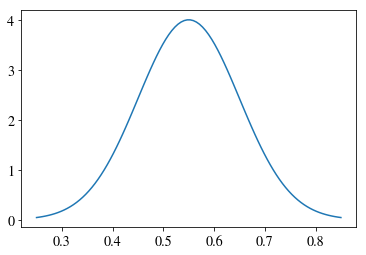

In [14]:
zz = np.linspace(zpk-0.3, zpk+0.3, 100)
sigmaz = 0.1
def Gaussian(z, p=(zpk, sigmaz)):
    zc, dz = p
    return np.exp(-0.5*(z-zc)**2/dz**2)
nz = Gaussian(zz)
nz /= np.trapz(nz, x=zz)
plt.plot(zz, nz)

BOSS galaxy count distribution

In [15]:
path = '/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/'

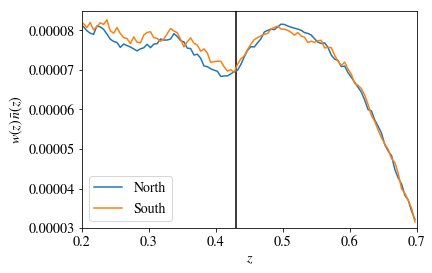

In [16]:
for sky in ["North", "South"]:
    zcen,zlow,zhigh,nbar,wfkp,shell_vol,ng = np.loadtxt(
        os.path.join(path, 
                     'CF/nbar_DR12v5_CMASSLOWZ_%s_om0p31_Pfkp10000.dat') % sky, unpack=True)
    imin = np.where((zcen>0.2) & (zcen<=0.7))[0]

    plt.plot(zcen[imin], wfkp[imin] * nbar[imin], label=r'%s' % sky)
plt.vlines(0.43, ymin= 0.00003, ymax = 0.0001 )
plt.xlabel(r'$z$')
plt.ylabel(r'$w(z) \, \bar n(z)$')
plt.ylim(0.00003, 0.000085)
plt.xlim(0.2, 0.7)
plt.legend()
plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/time/paper_fig/2021/nz.pdf', bbox_inches='tight')

0.5417282679817811


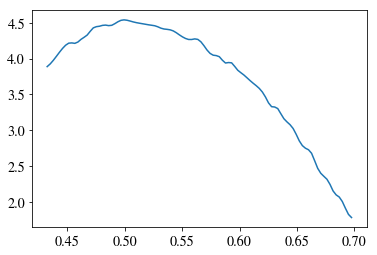

In [17]:
z, n = np.loadtxt(os.path.join(path, 'CF/z_nbar_DR12v5_CMASS_North.dat'), unpack=True)
n /= np.trapz(n, x=z)
zz = np.linspace(z[0], z[-1], 100)
nz = interp1d(z, n, kind='cubic')(zz)
nz /= np.trapz(nz, x=zz)
plt.plot(zz, nz)
print (np.trapz(zz * nz**2, x=zz) / np.trapz(nz**2, x=zz))

Growth function ratio

In [18]:
zpk = 0.55

In [19]:
dz = 0.1
r0 = M.scale_independent_growth_factor(zpk-dz) \
    * M.scale_independent_growth_factor(zpk+dz) / M.scale_independent_growth_factor(zpk)**2

Unequal time vs. mean equal time

In [20]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6, 'km': 0.7, 'knl': 0.7, 'optiresum': True, "with_stoch": True, 
        })
correlator.compute(cosmo, module='class')
eqpk = correlator.get(bdict)
##### ###
dz = 0.1
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6, 'km': 0.7, 'knl': 0.7, 'optiresum': True,  "with_stoch": True, 
    'with_nonequal_time': True, 'z1': zpk-dz, 'z2': zpk+dz,
        })
correlator.compute(cosmo, module='class')
uneqpk = correlator.get(bdict)

In [21]:
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [22]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6,  'km': 0.7, 'knl': 0.7, 'optiresum': True, "with_stoch": True,
    'with_redshift_bin': True, 'zz': zz,'nz': nz, 
})
correlator.compute(cosmo, module='class')
redpk = correlator.get(bdict)

In [23]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6,  'km': 0.7, 'knl': 0.7, 'optiresum': True, "with_stoch": True,
    'with_exact_time': True
                })
correlator.compute(cosmo, module='class')
exactpk = correlator.get(bdict)

Summary plot

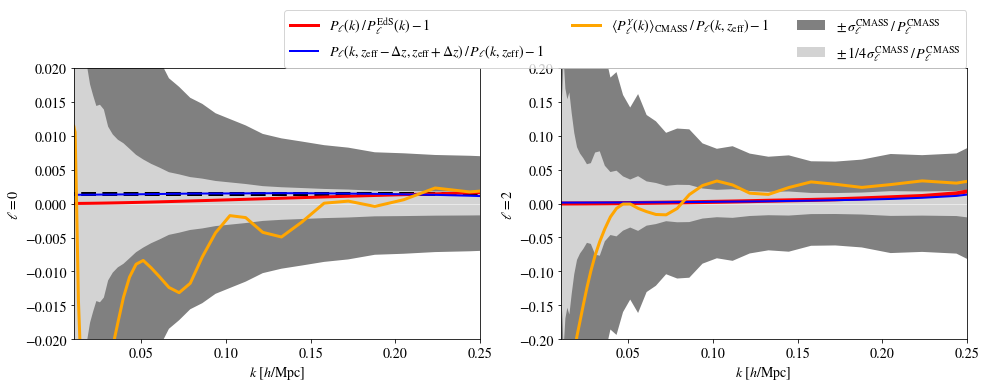

In [24]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
f.subplots_adjust(wspace=.2)
ax[0].plot(kd, 0*kd, 'white', linewidth=0.5)
ax[0].plot(kd, r0 * np.ones_like(kd)-1, 'k--', lw=4) #, label=r'$D(z_{\rm eff}+\Delta z) D(z_{\rm eff}+\Delta z)  \, / \, D(z_{\rm eff})^2-1$'
ax[0].plot(kd, exactpk[0]/eqpk[0]-1, 'red', lw=3, label=r'$P_\ell(k) \, / \, P_\ell^{\rm EdS}(k) - 1$')
ax[0].plot(kd, uneqpk[0]/eqpk[0]-1, 'blue', lw=2, label=r'$P_\ell(k, z_{\rm eff}-\Delta z, z_{\rm eff}+\Delta z) \, / \, P_\ell(k, z_{\rm eff})-1$')
ax[0].plot(kd, (redpk[0]-1.046/3e-4)/eqpk[0]-1, 'orange', lw=3, label=r'$\langle P_\ell^Y (k) \rangle_{\rm CMASS} \, / \, P_\ell(k, z_{\rm eff}) - 1$')
ax[0].fill_between(kd, -eb[0], eb[0], facecolor='grey')
ax[0].fill_between(kd, -eb[0]/4., eb[0]/4., facecolor='lightgrey')
ax[0].set_ylim(-0.02, +0.02)
ax[0].set_ylabel(r'$\ell=0$')
ax[0].set_xlim(0.01, 0.25)
ax[0].set_xlabel(r'$k$ [$h$/Mpc]')

ax[1].set_xlabel(r'$k$ [$h$/Mpc]')
ax[1].plot(kd, 0*kd, 'white', linewidth=0.5)
ax[1].plot(kd, exactpk[1]/eqpk[1]-1, 'red', lw=4)
ax[1].plot(kd, uneqpk[1]/eqpk[1]-1, 'blue', lw=2)
ax[1].plot(kd, redpk[1]/eqpk[1]-1, 'orange', lw=3)
ax[1].plot(kd, np.ones_like(kd), 'white', label=' ')
ax[1].fill_between(kd, -eb[1], eb[1], facecolor='grey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].fill_between(kd[0:], -eb[1,0:]/4., eb[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].set_ylim(-0.2, +0.2)
ax[1].set_ylabel(r'$\ell=2$')
ax[1].set_xlim(0.01, 0.25)
ax[1].set_xlabel(r'$k$ [$h$/Mpc]')

#f.legend(bbox_to_anchor=(0.34, 0.8), loc='upper left')
#f.legend(bbox_to_anchor=(0.845, 1.15), ncol=5, loc='upper right')
f.legend(bbox_to_anchor=(0.845, 1.07), ncol=3, loc='upper right')

plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/time/paper_fig/2021/pk.pdf', bbox_inches='tight')

### CF 

In [164]:
from scipy.interpolate import interp1d
sd, cfd, errd = np.loadtxt('../notebook/s_cf_err_CMASS.dat', unpack = True)
sd = sd.reshape(3,-1)[0]
ec = errd/cfd
ec = ec.reshape(3,-1)

In [216]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bCf', 'multipole': 2, 'xdata': sd, 'z': zpk, 'kmax': 0.6, 'km': 0.7, 'knl': 0.7, 
        })
correlator.compute(cosmo, module='class')
eqcf = correlator.get(bdict_cf)

In [228]:
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [229]:
dz = 0.1
correlator = pybird.Correlator()
correlator.set({
    'output': 'bCf', 'multipole': 2, 'xdata': sd, 'z': zpk, 'kmax': 0.6, 'km': 0.7, 'knl': 0.7, #'optiresum': True,
    'with_nonequal_time': True, 'z1': zpk-dz, 'z2': zpk+dz,
        })
correlator.compute(cosmo, module='class')
uneqcf = correlator.get(bdict_cf)

In [220]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bCf', 'multipole': 2, 'xdata': sd, 'z': zpk, 'kmax': 0.6,  'km': 0.7, 'knl': 0.7, 
    'with_redshift_bin': True, 'zz': zz,'nz': nz, 
})
correlator.compute(cosmo, module='class')
redcf = correlator.get(bdict_cf)

In [221]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bCf', 'multipole': 2, 'xdata': sd, 'z': zpk, 'kmax': 0.6,  'km': 0.7, 'knl': 0.7, 
    'with_exact_time': True
                })
correlator.compute(cosmo, module='class')
exactcf = correlator.get(bdict_cf)

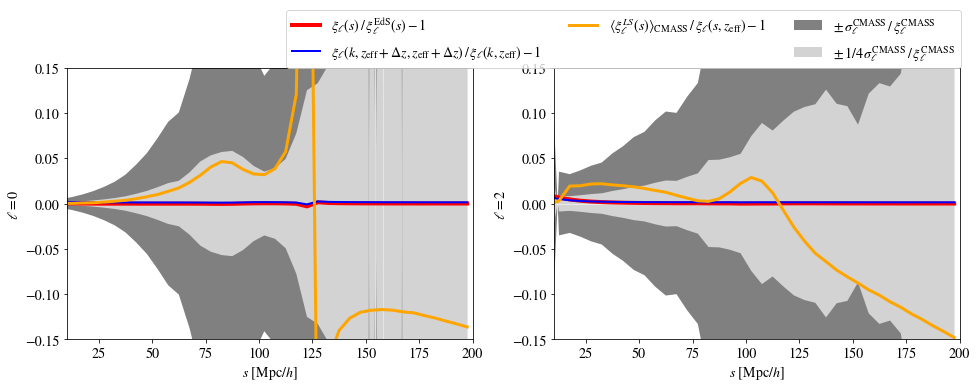

In [267]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
f.subplots_adjust(wspace=.2)
ax[0].plot(sd, 0*sd, 'white', linewidth=0.5)
#ax[0].plot(sd, r0 * np.ones_like(sd)-1, 'k--', lw=4) #, label=r'$D(z_{\rm eff}+\Delta z) D(z_{\rm eff}+\Delta z)  \, / \, D(z_{\rm eff})^2-1$'
ax[0].plot(sd, exactcf[0]/eqcf[0]-1, 'red', lw=4, label=r'$\xi_\ell(s) \, / \, \xi_\ell^{\rm EdS}(s) - 1$')
ax[0].plot(sd, uneqcf[0]/eqcf[0]-1, 'blue', lw=2, label=r'$\xi_\ell(k, z_{\rm eff}+\Delta z, z_{\rm eff}+\Delta z) \, / \, \xi_\ell(k, z_{\rm eff})-1$')
ax[0].plot(sd, (redcf[0])/eqcf[0]-1, 'orange', lw=3, label=r'$\langle \xi_\ell^{LS} (s) \rangle_{\rm CMASS} \, / \, \xi_\ell(s, z_{\rm eff}) - 1$')
ax[0].fill_between(sd, -ec[0], ec[0], facecolor='grey')
ax[0].fill_between(sd, -ec[0]/4., ec[0]/4., facecolor='lightgrey')
ax[0].set_ylim(-.15, +.15)
ax[0].set_ylabel(r'$\ell=0$')
ax[0].set_xlim(10, 200)
ax[0].set_xlabel(r'$s$ [Mpc/$h$]')

ax[1].set_xlabel(r'$s$ [Mpc/$h$]')
ax[1].plot(sd, 0*sd, 'white', linewidth=0.5)
ax[1].plot(sd, exactcf[1]/eqcf[1]-1, 'red', lw=4)
ax[1].plot(sd, uneqcf[1]/eqcf[1]-1, 'blue', lw=2)
ax[1].plot(sd, redcf[1]/eqcf[1]-1, 'orange', lw=3)
ax[1].plot(kd, np.ones_like(kd), 'white', label=' ')
ax[1].fill_between(sd, -ec[1], ec[1], facecolor='grey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, \xi_\ell^{\rm CMASS}$')
ax[1].fill_between(sd[0:], -ec[1,0:]/4., ec[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, \xi_\ell^{\rm CMASS}$')
ax[1].set_ylim(-.15, +.15)
ax[1].set_ylabel(r'$\ell=2$')
ax[1].set_xlim(10, 200)
ax[1].set_xlabel(r'$s$ [Mpc/$h$]')

#f.legend(bbox_to_anchor=(0.34, 0.8), loc='upper left')
#f.legend(bbox_to_anchor=(0.84, 1.07), ncol=2, loc='upper right')
f.legend(bbox_to_anchor=(0.84, 1.07), ncol=3, loc='upper right')

plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/time/paper_fig/2021/cf.pdf', bbox_inches='tight')

### Clustering quintessence

In [42]:
from importlib import reload
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [43]:
kd = np.linspace(0.005, 0.3)
zpk=0.57

In [44]:
rcosmo = {'omega_b': 0.02235, 'omega_cdm': 0.130, 'h': 0.68, 
         'ln10^{10}A_s': 3.0, 'n_s': 0.96}

In [34]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_exact_time': True
})
correlator.compute(rcosmo, module='class')
rpk = correlator.get(bdict)

In [45]:
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.130, 'h': 0.68, 
         'ln10^{10}A_s': 3.0, 'n_s': 0.96, 'w0_fld': -1.05, 'Omega_Lambda': 0., 'cs2_fld': 0}

In [36]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_exact_time': True
})
correlator.compute(cosmo, module='class')
wpk = correlator.get(bdict)

correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True,
})
correlator.compute(cosmo, module='class')
edspk = correlator.get(bdict)

correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True, 'with_exact_time': True
})
correlator.compute(cosmo, module='class')
qpk = correlator.get(bdict)

In [46]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True, 'with_exact_time': True
})
correlator.compute(cosmo, module='class')
old_qpk = correlator.get(bdict)

In [47]:
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.130, 'h': 0.68, 
         'ln10^{10}A_s': 3.0, 'n_s': 0.96, 'w0_fld': -0.95, 'Omega_Lambda': 0., 'cs2_fld': 0}

In [38]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_exact_time': True
})
correlator.compute(cosmo, module='class')
wpk2 = correlator.get(bdict)

correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True,
})
correlator.compute(cosmo, module='class')
edspk2 = correlator.get(bdict)

correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True, 'with_exact_time': True
})
correlator.compute(cosmo, module='class')
qpk2 = correlator.get(bdict)

In [48]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': kd[-1], "with_stoch": True, 'km': 0.7, 'knl': 0.7,
    'with_quintessence': True, 'with_exact_time': True
})
correlator.compute(cosmo, module='class')
old_qpk2 = correlator.get(bdict)

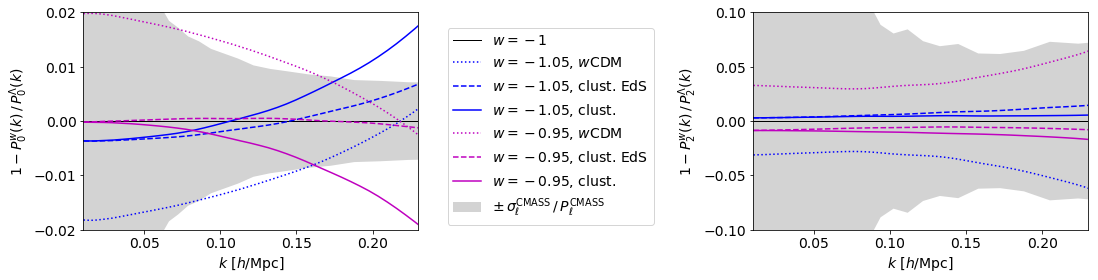

In [39]:
f, ax = plt.subplots(1, 2, figsize=(18,4))
f.subplots_adjust(wspace=1)
ax[0].plot(kd, 0*kd, 'k', linewidth=1, label=r'$w=-1$')
ax[0].plot(kd, 1-wpk[0]/rpk[0], 'b:', label=r'$w=-1.05$, $w$CDM')
ax[0].plot(kd, 1-edspk[0]/rpk[0], 'b--', label=r'$w=-1.05$, clust. EdS')
ax[0].plot(kd, 1-(qpk[0]+0*0.1/4e-4)/rpk[0], 'b', label=r'$w=-1.05$, clust.')

ax[0].plot(kd, 1-wpk2[0]/rpk[0], 'm:', label=r'$w=-0.95$, $w$CDM')
ax[0].plot(kd, 1-edspk2[0]/rpk[0], 'm--', label=r'$w=-0.95$, clust. EdS')
ax[0].plot(kd, 1-(qpk2[0]-0*0.1/4e-4)/rpk[0], 'm', label=r'$w=-0.95$, clust.')
ax[0].fill_between(kb, -eb[0], eb[0], facecolor='lightgrey')
# ax[0].fill_between(kb, -eb[0]/4., eb[0]/4., facecolor='lightgrey')
ax[0].set_ylim(-0.02, +0.02)
ax[0].set_ylabel(r'$1-P_0^{w}(k) \, / \, P_0^{\Lambda}(k)$')
ax[0].set_xlim(0.01, 0.23)
ax[0].set_xlabel(r'$k$ [$h$/Mpc]')

ax[1].set_xlabel(r'$k$ [$h$/Mpc]')
ax[1].plot(kd, 0*kd, 'k', linewidth=1)
ax[1].plot(kd, 1-wpk[1]/rpk[1], 'b:')
ax[1].plot(kd, 1-edspk[1]/rpk[1], 'b--')
ax[1].plot(kd, 1-qpk[1]/rpk[1], 'b')
ax[1].plot(kd, 1-wpk2[1]/rpk[1], 'm:')
ax[1].plot(kd, 1-edspk2[1]/rpk[1], 'm--')
ax[1].plot(kd, 1-qpk2[1]/rpk[1], 'm')
ax[1].fill_between(kb, -eb[1], eb[1], facecolor='lightgrey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
# ax[1].fill_between(kb[0:], -eb[1,0:]/4., eb[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].set_ylim(-0.1, +0.1)
ax[1].set_ylabel(r'$1-P_2^{w}(k) \, / \, P_2^{\Lambda}(k)$')
ax[1].set_xlim(0.01, 0.23)
ax[1].set_xlabel(r'$k$ [$h$/Mpc]')

f.legend(bbox_to_anchor=(0.34, 0.9), loc='upper left')

plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/quint/paper_fig/pk_newresum.pdf', bbox_inches='tight')

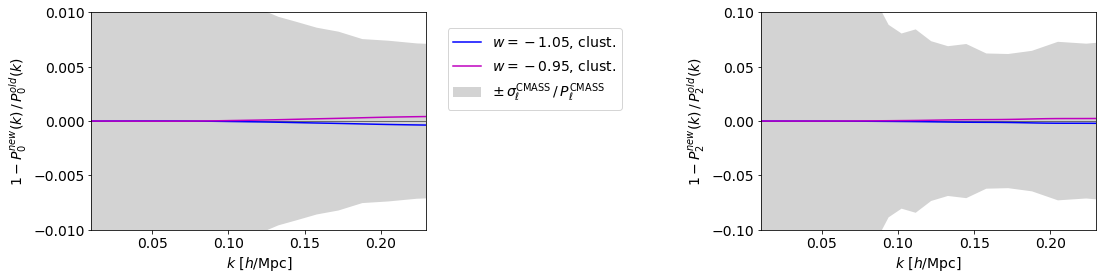

In [52]:
f, ax = plt.subplots(1, 2, figsize=(18,4))
f.subplots_adjust(wspace=1)
ax[0].plot(kd, 0*kd, 'k', linewidth=0.5)
ax[0].plot(kd, 1-qpk[0]/old_qpk[0], 'b', label=r'$w=-1.05$, clust.')
ax[0].plot(kd, 1-qpk2[0]/old_qpk2[0], 'm', label=r'$w=-0.95$, clust.')
ax[0].fill_between(kb, -eb[0], eb[0], facecolor='lightgrey')
# ax[0].fill_between(kb, -eb[0]/4., eb[0]/4., facecolor='lightgrey')
ax[0].set_ylim(-0.01, +0.01)
ax[0].set_ylabel(r'$1-P_0^{new}(k) \, / \, P_0^{old}(k)$')
ax[0].set_xlim(0.01, 0.23)
ax[0].set_xlabel(r'$k$ [$h$/Mpc]')

ax[1].set_xlabel(r'$k$ [$h$/Mpc]')
ax[1].plot(kd, 0*kd, 'k', linewidth=0.5)
ax[1].plot(kd, 1-qpk[1]/old_qpk[1], 'b')
ax[1].plot(kd, 1-qpk2[1]/old_qpk2[1], 'm')
ax[1].fill_between(kb, -eb[1], eb[1], facecolor='lightgrey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
# ax[1].fill_between(kb[0:], -eb[1,0:]/4., eb[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].set_ylim(-0.1, +0.1)
ax[1].set_ylabel(r'$1-P_2^{new}(k) \, / \, P_2^{old}(k)$')
ax[1].set_xlim(0.01, 0.23)
ax[1].set_xlabel(r'$k$ [$h$/Mpc]')

f.legend(bbox_to_anchor=(0.34, 0.9), loc='upper left')

plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/quint/paper_fig/pk_newresum_diff.pdf', bbox_inches='tight')

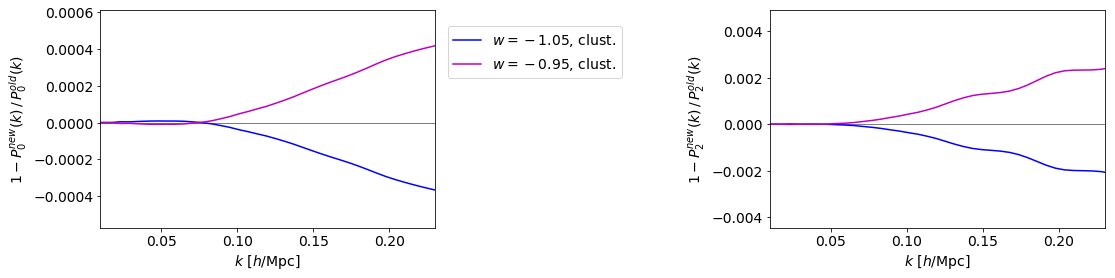

In [56]:
f, ax = plt.subplots(1, 2, figsize=(18,4))
f.subplots_adjust(wspace=1)
ax[0].plot(kd, 0*kd, 'k', linewidth=0.5)
ax[0].plot(kd, 1-qpk[0]/old_qpk[0], 'b', label=r'$w=-1.05$, clust.')
ax[0].plot(kd, 1-qpk2[0]/old_qpk2[0], 'm', label=r'$w=-0.95$, clust.')
#ax[0].fill_between(kb, -eb[0], eb[0], facecolor='lightgrey')
# ax[0].fill_between(kb, -eb[0]/4., eb[0]/4., facecolor='lightgrey')
#ax[0].set_ylim(-0.01, +0.01)
ax[0].set_ylabel(r'$1-P_0^{new}(k) \, / \, P_0^{old}(k)$')
ax[0].set_xlim(0.01, 0.23)
ax[0].set_xlabel(r'$k$ [$h$/Mpc]')

ax[1].set_xlabel(r'$k$ [$h$/Mpc]')
ax[1].plot(kd, 0*kd, 'k', linewidth=0.5)
ax[1].plot(kd, 1-qpk[1]/old_qpk[1], 'b')
ax[1].plot(kd, 1-qpk2[1]/old_qpk2[1], 'm')
#ax[1].fill_between(kb, -eb[1], eb[1], facecolor='lightgrey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
# ax[1].fill_between(kb[0:], -eb[1,0:]/4., eb[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
#ax[1].set_ylim(-0.1, +0.1)
ax[1].set_ylabel(r'$1-P_2^{new}(k) \, / \, P_2^{old}(k)$')
ax[1].set_xlim(0.01, 0.23)
ax[1].set_xlabel(r'$k$ [$h$/Mpc]')

f.legend(bbox_to_anchor=(0.34, 0.9), loc='upper left')

plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/quint/paper_fig/pk_newresum_diff_zoom.pdf', bbox_inches='tight')

## Exact formula

In [9]:
# # p = np.concatenate([ np.geomspace(1e-5, 0.015, 100, endpoint=False) , np.arange(0.015, self.co.kmax, 1e-3) ])
# p = np.concatenate([ np.geomspace(1e-5, 0.015, 30, endpoint=False) , np.arange(0.015, 0.3, 0.01) ])
# self.fftsettings = dict(Nmax=4096, xmin=sw[0], xmax=sw[-1]*100., bias=-1.6) # 1e-2 - 1e6 [Mpc/h]
# self.fft = FFTLog(**self.fftsettings)
# self.pPow = exp(np.einsum('n,s->ns', -self.fft.Pow-3., log(self.p)))
# self.M = np.empty(shape=(Nl, self.fft.Pow.shape[0]), dtype='complex')
# for l in range(Nl): self.M[l] = 4*pi * MPC(2*l, -0.5*self.fft.Pow)

# self.Coef = np.empty(shape=(self.co.Nl, Nl, self.co.Nk, self.fft.Pow.shape[0]), dtype='complex')
# for a in range(self.co.Nl):
#     for l in range(Nl):
#         for i,k in enumerate(self.co.k):
#             self.Coef[a,l,i] = (-1j)**(2*a) * 1j**(2*l) * self.fft.Coef(sw, Qal[a,l]*spherical_jn(2*a, k*sw), extrap = 'padding')

# sw = swindow_config_space[:,0]
# Qp = np.moveaxis(swindow_config_space[:,1:].reshape(-1,3), 0, -1 )[:Nl]
    
# self.Wal = self.p**2 * np.real( np.einsum('alkn,np,ln->alkp', self.Coef, self.pPow, self.M) )

In [10]:
z, _, _, n = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_cmass_ngc_v5.txt'), unpack=True)
n /= np.trapz(n, x=z)
zz = np.linspace(z[0], z[-1], 200)
nz = interp1d(z, n, kind='cubic')(zz)
zs, _, _, ns = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_cmass_sgc_v5.txt'), unpack=True)
ns /= np.trapz(ns, x=zs)
zl, _, _, nl = np.loadtxt(os.path.join('/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/density/Density_galaxies_lowz_ngc_v5.txt'), unpack=True)
nl /= np.trapz(nl, x=zl)

In [11]:
DD = M.scale_independent_growth_factor(0.57)**2

In [12]:
from scipy.special import spherical_jn
from cubature import cubature

ss = np.array([M.angular_distance(z)*(1+z) for z in zz])
D = np.array([M.scale_independent_growth_factor(z)*(1+z) for z in zz])
H = np.array([M.Hubble(z)*(1+z) for z in zz])
kernel = ss**2 / H * D * nz
ikernel = interp1d(zz, kernel, kind='cubic')
def iker(z): return ikernel(z)

# def comoving_distance(z): return M.angular_distance(z)*(1+z)
zz0 = np.linspace(0, 1, 1000)
ss0 =  np.array([M.angular_distance(z)*(1+z) for z in zz0])
iss0 = interp1d(zz0, ss0, kind='cubic')
def comoving_distance(z): return iss0(z)
    
# def nn(z): return interp1d(zz, nz, kind='cubic', bounds_error=False, fill_value='extrapolate')(z) 
# norm = np.trapz(np.array([comoving_distance(z)**2/M.Hubble(z)*nn(z) for z in zz]), x=zz)

def integrand(zz, k, p):
    z1 = zz[:, 0]
    z2 = zz[:, 1]
#     s1 = np.array([comoving_distance(z) for z in z1])
#     s2 = np.array([comoving_distance(z) for z in z2])
#     H1 = np.array([M.Hubble(z) for z in z1])
#     H2 = np.array([M.Hubble(z) for z in z2])
#     D1 = np.array([M.scale_independent_growth_factor(z) for z in z1])
#     D2 = np.array([M.scale_independent_growth_factor(z) for z in z2])
    s = np.array([comoving_distance(np.abs(za-zb)) for za, zb in zip(z1, z2)])
    return iker(z1) * iker(z2) * spherical_jn(0, k*s) * spherical_jn(0, p*s)
    # return 2/np.pi *s1**2 / H1 * s2**2 / H2 * nn(z1) * nn(z2) * D1 * D2 / norm * spherical_jn(0, k*s) * spherical_jn(0, p*s)

In [13]:
kk = np.linspace(0.1, 0.3, 10)
pp = [kk[0]]
# pp = np.concatenate([ np.geomspace(1e-3, 0.02, 10, endpoint=False) , np.arange(0.02, 0.30, 0.01) ])
dd = np.zeros(shape=(len(kk), len(pp)))
for i, k in enumerate(kk):
    for j, p in enumerate(pp):
        val, err = cubature(integrand, 2, 1, np.array([zz[0], zz[0]])+1e-3, np.array([zz[-1], zz[-1]])-1e-3, args=(k,p), 
                            abserr=1e-4, relerr=1e-4, maxEval=0, adaptive='p', vectorized=True)
        dd[i,j] = val

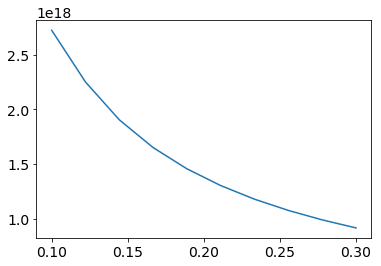

In [16]:
plt.plot(kk, dd)

In [22]:
pt = np.concatenate([ np.geomspace(1e-3, 0.02, 50, endpoint=False) , np.arange(0.02, 0.29, 1e-3) ])
dpt = np.concatenate([[0], pt[1:] - pt[:-1]])
ddt = interp1d(pp, dd, axis=-1, kind='cubic')(pt) * dpt

In [23]:
pk = np.ones_like(pt)
test = np.einsum('kp,p->k', ddt, pk)

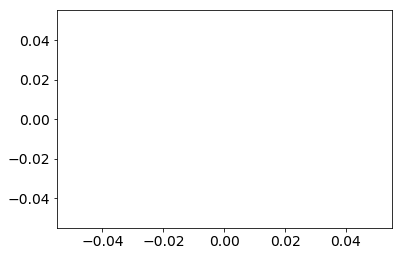

In [24]:
plt.plot(kk, test)
# plt.plot(pt, DD* pk)

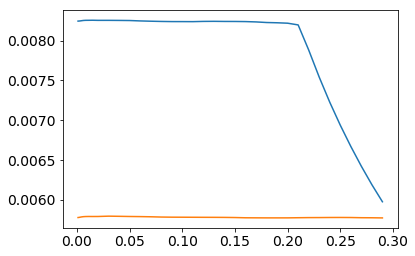

In [125]:
plt.plot(pp, dd[5])
plt.plot(pp, dd[-1])

In [80]:
print (M.scale_independent_growth_factor(0.57)**2)

0.5485622859438541


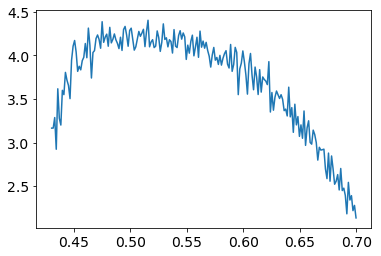

In [29]:
plt.plot(zz, nz)